In [1]:
import numpy as np
import matplotlib.pyplot as plt
import json

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
plt.rcParams['mathtext.fontset'] = 'stix'  # The setting of math font

In [2]:
data_ours = json.load(open("validate-ours.json"))
data_optuna = json.load(open("validate-optuna.json"))

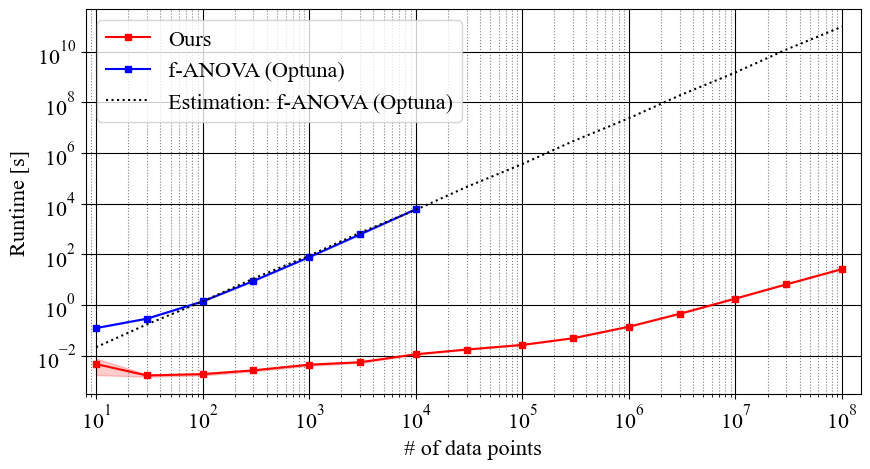

In [3]:
_, ax = plt.subplots(figsize=(10, 5))

x, m, s = [], [], []
for N, result in data_ours.items():
    x.append(int(N))
    m.append(np.mean(result["runtime"]))
    s.append(np.std(result["runtime"]) / np.sqrt(10))

x, m, s = map(np.asarray, [x, m, s])
dx = x.copy()
ax.plot(x, m, color="red", marker="s", markersize=5, label="Ours")
ax.fill_between(x, m - s, m + s, alpha=0.2, color="red")

x, m, s = [], [], []
for N, result in data_optuna.items():
    x.append(int(N))
    m.append(np.mean(result["runtime"]))
    s.append(np.std(result["runtime"]) / np.sqrt(10))

x, m, s = map(np.asarray, [x, m, s])

ax.plot(x, m, color="blue", marker="s", markersize=5, label="f-ANOVA (Optuna)")
est = np.asarray([m[2] * 8 ** (i - 2) for i in range(dx.size)])
ax.plot(dx, est, linestyle="dotted", color="black", label="Estimation: f-ANOVA (Optuna)")
ax.fill_between(x, m - s, m + s, alpha=0.2, color="blue")

ax.set_xlim(8, 1.5 * 10 ** 8)
ax.set_xlabel("# of data points")
ax.set_ylabel("Runtime [s]")
ax.set_xscale("log")
ax.set_yscale("log")
ax.legend()
ax.grid(which='minor', color='gray', linestyle=':')
ax.grid(which='major', color='black')
plt.savefig("figs/runtime-benchmark.pdf", bbox_inches="tight")

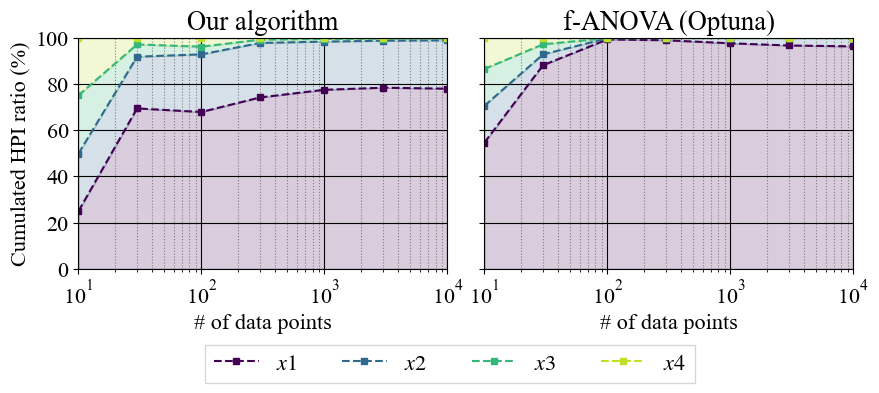

In [4]:
def proc(data):
    hpi_dict = {}
    v0 = 0
    for k, v in data.items():
        if k == "runtime":
            continue
        hpi_dict[k] = np.mean(v)
        v0 += hpi_dict[k]

    hpi_dict = {k: v / v0 * 100 for k, v in hpi_dict.items()}
    return hpi_dict

_, axes = plt.subplots(
    figsize=(10, 3),
    ncols=2,
    sharex=True,
    sharey=True,
    gridspec_kw=dict(wspace=0.1)
)
sizes = [10, 30, 100, 300, 1000, 3000, 10000]

def plot_hpi_trans(ax, data):
    results = {f"x{d+1}": [] for d in range(4)}
    for size in sizes:
        result = proc(data[str(size)])
        for k, v in result.items():
            results[k].append(v)
    
    lines, labels = [], []
    prev = np.zeros_like(sizes)
    cur = np.asarray(results["x1"])
    cm = plt.get_cmap("viridis")
    for d in range(1, 4):
        color = cm((d - 1) / 3)
        line, = ax.plot(sizes, cur, color=color, linestyle="dashed", marker="s", markersize=5)
        ax.fill_between(sizes, prev, cur, color=color, alpha=0.2)
        prev = cur.copy()
        cur += np.asarray(results[f"x{d+1}"])
        lines.append(line)
        labels.append(f"$x{d}$")
    else:
        color = cm(0.9)
        line, = ax.plot(sizes, cur, color=color, linestyle="dashed", marker="s", markersize=5)
        ax.fill_between(sizes, prev, cur, color=color, alpha=0.2)
        lines.append(line)
        labels.append("$x4$")

    ax.set_xlabel("# of data points")
    ax.set_xscale("log")
    ax.set_xlim(10, 10 ** 4)
    ax.set_ylim(0, 100)
    ax.grid(which='minor', color='gray', linestyle=':')
    ax.grid(which='major', color='black')
    return lines, labels

ax = axes[0]
ax.set_title("Our algorithm")
ax.set_ylabel("Cumulated HPI ratio (%)")
plot_hpi_trans(ax, data_ours)

ax = axes[1]
ax.set_title("f-ANOVA (Optuna)")
lines, labels = plot_hpi_trans(ax, data_optuna)
ax.legend(
    handles=lines,
    labels=labels,
    bbox_to_anchor=(0.6, -0.28),  # ここは調整が必要です
    fancybox=False,
    ncol=len(labels)
)
plt.savefig("figs/info-loss-benchmark.pdf", bbox_inches="tight")

In [5]:
from parzen_estimator import NumericalParzenEstimator, NumericalUniform

D = 4
lb, ub, dim = -5, 5, 4
n_samples = 10000
n_grids = 1000
rng = np.random.RandomState(0)
X = rng.random((dim, n_samples)) * (ub - lb) + lb
X_rounded = np.round(((X + lb) / (ub - lb)) * n_grids) / n_grids * (ub - lb) - lb
dx = np.linspace(lb, ub, n_grids + 1)

def func(X: np.ndarray) -> np.ndarray:
    assert X.shape[0] == D
    W = np.asarray([5 ** -i for i in range(D)])
    Z = np.zeros(X.shape[-1])
    for d in range(D):
        mask = np.abs(X[d]) < 1
        Z += W[(mask + d) % D] * X[d] ** 2

    return Z


F = func(X)

g1, g2 = 0.1, 0.01
n_top1, n_top2 = int(n_samples * g1), int(n_samples * g2)
order = np.argsort(F)
Xg1 = X[:, order[:n_top1]]
Xg2 = X[:, order[:n_top2]]

pes0 = [
    NumericalUniform(lb=lb, ub=ub)
    for d in range(D)
]
pes1 = [
    NumericalParzenEstimator(samples=Xg1[d], lb=lb, ub=ub, compress=True)
    for d in range(D)
]
pes2 = [
    NumericalParzenEstimator(samples=Xg2[d], lb=lb, ub=ub, compress=True)
    for d in range(D)
]


def pearson_divergence(
    pe1: NumericalParzenEstimator,
    pe2: NumericalParzenEstimator,
) -> float:
    pdf1 = pe1(dx)
    pdf2 = pe2(dx)
    return pdf2 @ ((pdf1 / pdf2 - 1) ** 2) / np.sum(pdf2)

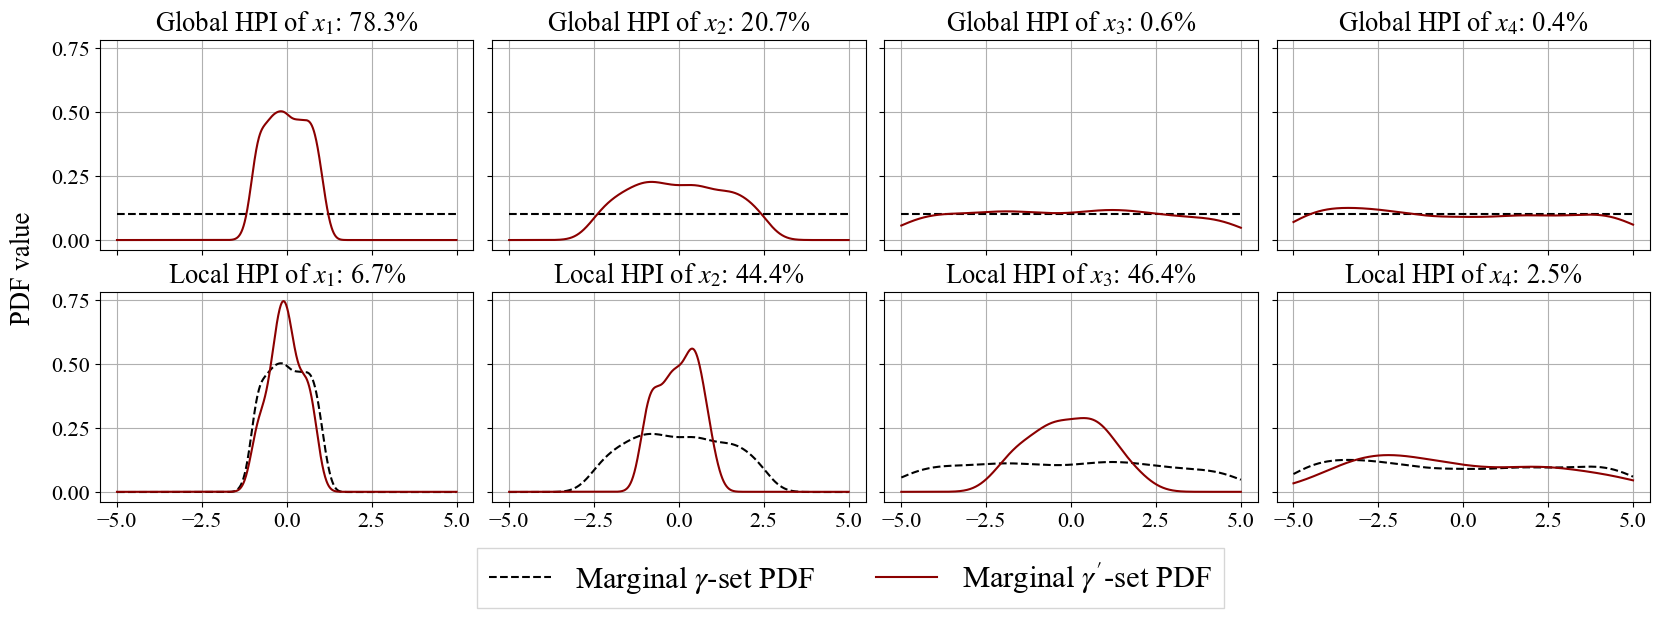

In [6]:
fig, axes = plt.subplots(
    ncols=4,
    nrows=2,
    sharex=True,
    sharey=True,
    figsize=(20, 6),
    gridspec_kw={"wspace": 0.05}
)

lines = []
local_hpi, global_hpi = {}, {}
local_sum, global_sum = 0, 0
for d in range(dim):
    pdf0, pdf1, pdf2 = pes0[d](dx), pes1[d](dx), pes2[d](dx)
    global_hpi[f"x{d+1}"] = pearson_divergence(pe1=pes1[d], pe2=pes0[d])
    global_sum += global_hpi[f"x{d+1}"]
    local_hpi[f"x{d+1}"] = pearson_divergence(pe1=pes2[d], pe2=pes1[d])
    local_sum += local_hpi[f"x{d+1}"]
else:
    global_hpi = {k: 100 * v / global_sum for k, v in global_hpi.items()}
    local_hpi = {k: 100 * v / local_sum for k, v in local_hpi.items()}

for d in range(dim):
    pdf0, pdf1, pdf2 = pes0[d](dx), pes1[d](dx), pes2[d](dx)
    global_imp, local_imp = global_hpi[f"x{d+1}"], local_hpi[f"x{d+1}"]
    ax = axes[0][d]
    ax.plot(dx, pdf0, color="black", linestyle="dashed")
    ax.plot(dx, pdf1, color="darkred")
    ax.set_title(f"Global HPI of $x_{d+1}$: {global_imp:.1f}%")
    ax.grid()

    ax = axes[1][d]
    line1, = ax.plot(dx, pdf1, color="black", linestyle="dashed")
    line2, = ax.plot(dx, pdf2, color="darkred")
    ax.set_title(f"Local HPI of $x_{d+1}$: {local_imp:.1f}%")
    ax.grid()

    if d == dim - 1:
        lines = [line1, line2]
        labels = ["Marginal $\gamma$-set PDF", "Marginal $\gamma^\prime$-set PDF"]

fig.supylabel("PDF value", x=0.08)
axes[-1][1].legend(
    handles=lines,
    labels=labels,
    fontsize=22,
    bbox_to_anchor=(2.0, -0.15),
    fancybox=False,
    shadow=False,
    ncol=len(labels)
)

plt.savefig(f'figs/space-reduction-usage.pdf', bbox_inches='tight')